<a href="https://colab.research.google.com/github/LuisCGit/6.484-reinforcement-learning/blob/main/lfd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spring 2022 6.484 Computational Sensorimotor Learning Assignment 4

In this assignment, we will work on learning from demonstrations. 

You will need to **answer the bolded questions** and **fill in the missing code snippets** (marked by **TODO**).

There are **130** total points to be had in this PSET.  `ctrl-f` for "pts" to ensure you don't miss questions.

**_Please fill in your name below:_**

**Name**: Luis Costa Laveron

In [1]:
!pip install pybullet > /dev/null 2>&1
!pip install git+https://github.com/taochenshh/easyrl.git > /dev/null 2>&1
!pip install git+https://github.com/Improbable-AI/airobot.git > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [17]:
import os
import torch
import gym
import pprint
import time
import pybullet as p
import pybullet_data as pd
import pybullet_envs
import airobot as ar
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from typing import Any
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pylab
from dataclasses import dataclass
from airobot import Robot
from airobot.utils.common import quat2euler
from airobot.utils.common import euler2quat
from gym import spaces
from gym.envs.registration import registry, register
from gym.wrappers import Monitor
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from tqdm.notebook import tqdm
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from pathlib import Path
from copy import deepcopy
from itertools import count
from easyrl.agents.ppo_agent import PPOAgent
from easyrl.utils.common import save_traj
from easyrl.configs import cfg
from easyrl.configs import set_config
from easyrl.configs.command_line import cfg_from_cmd
from easyrl.engine.ppo_engine import PPOEngine
from easyrl.models.categorical_policy import CategoricalPolicy
from easyrl.models.diag_gaussian_policy import DiagGaussianPolicy
from easyrl.models.mlp import MLP
from easyrl.models.value_net import ValueNet
from easyrl.agents.base_agent import BaseAgent
from easyrl.utils.torch_util import DictDataset
from easyrl.utils.torch_util import load_state_dict
from easyrl.utils.torch_util import load_torch_model
from easyrl.runner.nstep_runner import EpisodicRunner
from easyrl.utils.torch_util import save_model
from easyrl.utils.torch_util import action_entropy
from easyrl.utils.torch_util import action_from_dist
from easyrl.utils.torch_util import action_log_prob
from easyrl.utils.torch_util import clip_grad
from easyrl.utils.common import set_random_seed
from easyrl.utils.gym_util import make_vec_env
from easyrl.utils.common import load_from_json
from easyrl.utils.torch_util import freeze_model
from easyrl.utils.torch_util import move_to
from easyrl.utils.torch_util import torch_float
from easyrl.utils.torch_util import torch_to_np
from base64 import b64encode
from IPython import display as ipythondisplay
import seaborn as sns
import pandas
import pickle
%matplotlib inline

In [3]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [4]:
def play_video(video_dir, video_file=None, video_id=None):
    if video_file is None:
        video_dir = Path(video_dir)
        video_files = list(video_dir.glob(f'**/render_video.mp4'))
        if video_id is not None:
            video_files = [x for x in video_files if f'{video_id:06d}' in x.as_posix()]
        video_files.sort()
        video_file = video_files[-1]
    else:
        video_file = Path(video_file)
    compressed_file = video_file.parent.joinpath('comp.mp4')
    os.system(f"ffmpeg -i {video_file} -filter:v 'setpts=2.0*PTS' -vcodec libx264 {compressed_file.as_posix()}")
    mp4 = open(compressed_file.as_posix(),'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    ipythondisplay.display(HTML("""
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url))

# read tf log file
def read_tf_log(log_dir):
    log_dir = Path(log_dir)
    log_files = list(log_dir.glob(f'**/events.*'))
    if len(log_files) < 1:
        return None
    log_file = log_files[0]
    event_acc = EventAccumulator(log_file.as_posix())
    event_acc.Reload()
    tags = event_acc.Tags()
    try:
        scalar_success = event_acc.Scalars('train/episode_success')
        success_rate = [x.value for x in scalar_success]
        steps = [x.step for x in scalar_success]
        scalar_return = event_acc.Scalars('train/episode_return/mean')
        returns = [x.value for x in scalar_return]
    except:
        return None
    return steps, returns, success_rate


def plot_curves(data_dict, title):
    # {label: [x, y]}
    fig, ax = plt.subplots(figsize=(4, 3))
    labels = data_dict.keys()
    for label, data in data_dict.items():
        x = data[0]
        y = data[1]
        ax.plot(x, y, label=label)
    ax.set_title(title)
    ax.legend()

def set_random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

# set random seed
seed = 0
set_random_seed(seed=seed)


# Environment (Pusher)

In this assignment, we will use the Pusher environment that we used in HW3. We modified the environment so that the goal locations are randomly sampled within a small region.

In [5]:
class URRobotPusherGym(gym.Env):
    def __init__(self,
                 action_repeat=10,
                 gui=False,
                 max_episode_length=30,
                 dist_threshold=0.05):
        self._action_repeat = action_repeat
        self._max_episode_length = max_episode_length
        self._dist_threshold = dist_threshold

        self._xy_bounds = np.array([[0.23, 0.78],  # [xmin, xmax]
                                    [-0.35, 0.3]])  # [ymin, ymax]
        self._goal_bounds = np.array([[0.3, 0.65],  # [xmin, xmax]
                                      [0.0, 0.25]])  # [ymin, ymax]
        self.robot = Robot('ur5e_stick',
                           pb_cfg={'gui': gui,
                                   'realtime': False,
                                   'opengl_render': torch.cuda.is_available()})
        self._arm_reset_pos = np.array([-0.38337763,
                                        -2.02650575,
                                        -2.01989619,
                                        -0.64477803,
                                        1.571439041,
                                        -0.38331266])
        self._table_id = self.robot.pb_client.load_urdf('table/table.urdf',
                                                        [.5, 0, 0.4],
                                                        euler2quat([0, 0, np.pi / 2]),
                                                        scaling=0.9)

        # create a ball at the start location (for visualization purpose)
        self._start_pos = np.array([0.45, -0.32, 1.0])
        self._start_urdf_id = self.robot.pb_client.load_geom('sphere', size=0.04, mass=0,
                                                             base_pos=self._start_pos,
                                                             rgba=[1, 1, 0, 0.8])

        # create a ball at the goal location
        self._goal_pos = np.array([0.5, 0.2, 1.0])
        self._goal_urdf_id = self.robot.pb_client.load_geom('sphere', size=0.04, mass=0,
                                                            base_pos=self._goal_pos,
                                                            rgba=[1, 0, 0, 0.8])

        # disable the collision checking between the robot and the ball at the goal location
        for i in range(self.robot.pb_client.getNumJoints(self.robot.arm.robot_id)):
            self.robot.pb_client.setCollisionFilterPair(self.robot.arm.robot_id,
                                                        self._goal_urdf_id,
                                                        i,
                                                        -1,
                                                        enableCollision=0)
        # disable the collision checking between the robot and the ball at the start location
        for i in range(self.robot.pb_client.getNumJoints(self.robot.arm.robot_id)):
            self.robot.pb_client.setCollisionFilterPair(self.robot.arm.robot_id,
                                                        self._start_urdf_id,
                                                        i,
                                                        -1,
                                                        enableCollision=0)

        self._box_pos = np.array([0.45, -0.1, 0.996])
        self._box_id = self.robot.pb_client.load_geom('cylinder', size=[0.05, 0.05], mass=1.,
                                                      base_pos=self._box_pos,
                                                      rgba=[1., 0.6, 0.6, 1])

        self.robot.pb_client.changeDynamics(self._box_id, -1, lateralFriction=0.9)

        self.robot.pb_client.setCollisionFilterPair(self._box_id,
                                                    self._start_urdf_id,
                                                    -1,
                                                    -1,
                                                    enableCollision=0)
        self.robot.pb_client.setCollisionFilterPair(self._box_id,
                                                    self._goal_urdf_id,
                                                    -1,
                                                    -1,
                                                    enableCollision=0)

        self._action_bound = 1.0
        self._ee_pos_scale = 0.04
        self._action_high = np.array([self._action_bound] * 2)
        self.action_space = spaces.Box(low=-self._action_high,
                                       high=self._action_high,
                                       dtype=np.float32)
        state_low = np.full(len(self._get_obs()), -float('inf'))
        state_high = np.full(len(self._get_obs()), float('inf'))
        self.observation_space = spaces.Box(state_low,
                                            state_high,
                                            dtype=np.float32)
        self.reset()

    def reset(self):
        self.robot.arm.set_jpos(self._arm_reset_pos, ignore_physics=True)
        self.robot.pb_client.reset_body(self._box_id, base_pos=self._box_pos)

        starts = self._goal_bounds[:, 0]
        ends = self._goal_bounds[:, 1]
        width = ends - starts
        # different from HW3, we are setting the goal to a random location
        ran = np.random.random(2)
        goal_pos = starts + width * ran
        goal_pos = np.append(goal_pos, 1)
        self._goal_pos = goal_pos
        self.robot.pb_client.reset_body(self._goal_urdf_id, base_pos=self._goal_pos)

        self._t = 0
        self._ref_ee_pos = self.robot.arm.get_ee_pose()[0]
        self._ref_ee_ori = self.robot.arm.get_ee_pose()[1]
        return self._get_obs()

    def step(self, action):
        previous_state = self._get_obs()
        collision = self._apply_action(action)
        self._t += 1
        state = self._get_obs()

        reward, info = self._get_reward(state=state, action=action, previous_state=previous_state)
        done = self._t >= self._max_episode_length or info['success']
        info['collision'] = collision
        return state, reward, done, info

    def _get_reward(self, state, action, previous_state):
        object_pos = state[2:4]
        dist_to_goal = np.linalg.norm(object_pos - self._goal_pos[:2])
        success = dist_to_goal < self._dist_threshold
        gripper_pos = state[:2]
        prev_object_pos = previous_state[2:4]
        prev_dist_to_goal = np.linalg.norm(prev_object_pos - self._goal_pos[:2])

        gripper_obj_dist = np.linalg.norm(gripper_pos - object_pos)
        reach_reward = -gripper_obj_dist
        touch_reward = int(gripper_obj_dist < 0.08) * 0.03 if dist_to_goal < prev_dist_to_goal else 0

        push_reward = np.exp(-dist_to_goal * 8) * 1. if touch_reward > 0 else 0
        if success:
            push_reward += 10
        reward = touch_reward + push_reward + reach_reward
        info = dict(success=success)
        return reward, info

    def _get_obs(self):
        gripper_pos = self.robot.arm.get_ee_pose()[0][:2]
        object_pos, object_quat = self.robot.pb_client.get_body_state(self._box_id)[:2]
        state = np.concatenate([gripper_pos, object_pos[:2], self._goal_pos[:2]])
        return state

    def _apply_action(self, action):
        if not isinstance(action, np.ndarray):
            action = np.array(action).flatten()
        if action.size != 2:
            raise ValueError('Action should be [d_x, d_y].')
        # we set dz=0
        action = np.append(action, 0)
        pos, quat, rot_mat, euler = self.robot.arm.get_ee_pose()
        pos += action[:3] * self._ee_pos_scale
        pos[2] = self._ref_ee_pos[2]
        # if the new position is out of the bounds, then we don't apply the action
        if not np.logical_and(np.all(pos[:2] >= self._xy_bounds[:, 0]),
                              np.all(pos[:2] <= self._xy_bounds[:, 1])):
            return False

        # move the end-effector to the new position
        jnt_pos = self.robot.arm.compute_ik(pos, ori=self._ref_ee_ori)
        for step in range(self._action_repeat):
            self.robot.arm.set_jpos(jnt_pos)
            self.robot.pb_client.stepSimulation()

        return False

    def render(self, mode='human', **kwargs):
        robot_base = self.robot.arm.robot_base_pos
        self.robot.cam.setup_camera(focus_pt=robot_base,
                                    dist=2,
                                    yaw=85,
                                    pitch=-20,
                                    roll=0)
        rgb, _ = self.robot.cam.get_images(get_rgb=True,
                                           get_depth=False)
        return rgb


module_name = __name__

env_name = 'URPusher-v1'
if env_name in registry.env_specs:
    del registry.env_specs[env_name]
register(
    id=env_name,
    entry_point=f'{module_name}:URRobotPusherGym',
)

# Learning from Demonstrations

To generate a dataset of demonstrations to learn from, we've provided you a pre-trained expert model.

In [6]:
# Download the expert model
!wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1vlOBeo3caEbl17JEEyxRWbCnFZ--dyXH' -O pusher_expert_model.pt

will be placed in the single file you specified.

--2022-03-03 05:07:40--  https://docs.google.com/uc?export=download&id=1vlOBeo3caEbl17JEEyxRWbCnFZ--dyXH
Resolving docs.google.com (docs.google.com)... 74.125.195.100, 74.125.195.139, 74.125.195.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-00-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/uocu88npdhn0co2pbg69eo28v0vp04r3/1646284050000/13713566268573616286/*/1vlOBeo3caEbl17JEEyxRWbCnFZ--dyXH?e=download [following]
--2022-03-03 05:07:40--  https://doc-0k-00-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/uocu88npdhn0co2pbg69eo28v0vp04r3/1646284050000/13713566268573616286/*/1vlOBeo3caEbl17JEEyxRWbCnFZ--dyXH?e=download
Resolving doc-0k-00-docs.googleusercontent.com (doc-0k-00-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-0k-

## Utility functions

In [7]:
def create_actor(env):
    ob_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    actor_body = MLP(input_size=ob_dim,
                    hidden_sizes=[64],
                    output_size=64,
                    hidden_act=nn.Tanh,
                    output_act=nn.Tanh)
    actor = DiagGaussianPolicy(actor_body,
                               in_features=64,
                               action_dim=action_dim)
    return actor

def load_expert_agent(env, device, expert_model_path='pusher_expert_model.pt'):
    expert_actor = create_actor(env=env)
    expert_agent = BasicAgent(actor=expert_actor)
    print(f'Loading expert model from: {expert_model_path}.')
    ckpt_data = torch.load(expert_model_path, map_location=torch.device(f'{device}'))
    load_state_dict(expert_agent.actor,
                    ckpt_data['actor_state_dict'])
    freeze_model(expert_agent.actor)
    return expert_agent

def generate_demonstration_data(expert_agent, env, num_trials):
    return run_inference(expert_agent, env, num_trials, return_on_done=True)

def run_inference(agent, env, num_trials, return_on_done=False, sample=True, disable_tqdm=False, render=False):
    runner = EpisodicRunner(agent=agent, env=env)
    trajs = []
    for trial_id in tqdm(range(num_trials), desc='Run', disable=disable_tqdm):
        env.reset()
        traj = runner(time_steps=cfg.alg.episode_steps,
                      sample=sample,
                      return_on_done=return_on_done,
                      evaluation=True,
                      render_image=render)
        trajs.append(traj)
    return trajs

def eval_agent(agent, env, num_trials, disable_tqdm=False, render=False):
    trajs = run_inference(agent, env, num_trials, return_on_done=True, 
                          disable_tqdm=disable_tqdm, render=render)
    tsps = []
    successes = []
    rets = []
    for traj in trajs:
        tsps = traj.steps_til_done.copy().tolist()
        rewards = traj.raw_rewards
        infos = traj.infos
        for ej in range(rewards.shape[1]):
            ret = np.sum(rewards[:tsps[ej], ej])
            rets.append(ret)
            successes.append(infos[tsps[ej] - 1][ej]['success'])
        if render:
            save_traj(traj, 'tmp')
    ret_mean = np.mean(rets)
    ret_std = np.std(rets)
    success_rate = np.mean(successes)
    return success_rate, ret_mean, ret_std, rets, successes

In [8]:
@dataclass
class BasicAgent:
    actor: nn.Module

    def __post_init__(self):
        move_to([self.actor],
                device=cfg.alg.device)

    @torch.no_grad()
    def get_action(self, ob, sample=True, *args, **kwargs):
        t_ob = torch_float(ob, device=cfg.alg.device)
        # the policy returns a multi-variate gaussian distribution
        act_dist, _ = self.actor(t_ob)
        # sample from the distribution
        action = action_from_dist(act_dist,
                                  sample=sample)
        # get the log-probability of the sampled actions
        log_prob = action_log_prob(action, act_dist)
        # get the entropy of the action distribution
        entropy = action_entropy(act_dist, log_prob)
        action_info = dict(
            log_prob=torch_to_np(log_prob),
            entropy=torch_to_np(entropy),
        )
        return torch_to_np(action), action_info


In [9]:
def set_configs(exp_name='bc'):
    set_config('ppo')
    cfg.alg.seed = seed
    cfg.alg.num_envs = 1
    cfg.alg.episode_steps = 150
    cfg.alg.max_steps = 600000
    cfg.alg.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    cfg.alg.env_name = 'URPusher-v1'
    cfg.alg.save_dir = Path.cwd().absolute().joinpath('data').as_posix()
    cfg.alg.save_dir += f'/{exp_name}'
    setattr(cfg.alg, 'diff_cfg', dict(save_dir=cfg.alg.save_dir))

    print(f'====================================')
    print(f'      Device:{cfg.alg.device}')
    print(f'====================================')

## Generating demonstrations

Now that you've downloaded the expert policy model, let's load the expert agent.

In [10]:
# load the expert agent
set_configs()
env = make_vec_env(cfg.alg.env_name,
                   cfg.alg.num_envs,
                   seed=cfg.alg.seed)
expert_agent = load_expert_agent(env, device=cfg.alg.device)

[INFO][2022-03-03 05:07:41]: Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
[INFO][2022-03-03 05:07:41]: Creating 1 environments.
[INFO][2022-03-03 05:07:41]: Load in OpenGL!


      Device:cuda


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Loading expert model from: pusher_expert_model.pt.


Let's check how good the expert policy is and visualize its performance using `eval_agent` which takes an agent and evaluates it in a specified environment. This function will return to you the succes rate over all trajectories, the mean and standard deviation of total returns, the total returns of each trajectory, and the success of each trajectory.

In [12]:
success_rate, ret_mean, ret_std, rets, successes = eval_agent(expert_agent, env, 500)
# you might see some variance in the success rate here, 
# if you rollout the policies more times, the success rate will be more stable
print(f'Expert policy success rate:{success_rate}')

Run:   0%|          | 0/500 [00:00<?, ?it/s]

Expert policy success rate:0.868


In [13]:
# if you set `render=True`, it will save each evaluation trajectory in `tmp`
# and you can use `play_video` to visually check the trajectory
success_rate, ret_mean, ret_std, rets, successes = eval_agent(expert_agent, env, 5, render=True)

Run:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
play_video('tmp', video_id=2)

Finally, let's generate a dataset of 50 expert demonstrations.

In [15]:
expert_trajs = generate_demonstration_data(expert_agent=expert_agent,
                                           env=env,
                                           num_trials=50)

Run:   0%|          | 0/50 [00:00<?, ?it/s]

## Behavior Cloning (BC)

Now that we have expert demonstrations, let's use supervised learning (behavior cloning) to clone expert behavior. 

In [19]:
class TrajDataset(Dataset):
    def __init__(self, trajs):
        states = []
        actions = []
        for traj in trajs:
            states.append(traj.obs)
            actions.append(traj.actions)
        self.states = np.concatenate(states, axis=0)
        self.actions = np.concatenate(actions, axis=0)

    def __len__(self):
        return self.states.shape[0]

    def __getitem__(self, idx):
        sample = dict()
        sample['state'] = self.states[idx]
        sample['action'] = self.actions[idx]
        return sample
    
    def add_traj(self, traj=None, states=None, actions=None):
        if traj is not None:
            self.states = np.concatenate((self.states, traj.obs), axis=0)
            self.actions = np.concatenate((self.actions, traj.actions), axis=0)
        else:
            self.states = np.concatenate((self.states, states), axis=0)
            self.actions = np.concatenate((self.actions, actions), axis=0)            

def train_bc_agent(agent, trajs, max_epochs=5000, batch_size=256, lr=0.0005, disable_tqdm=True):
    dataset = TrajDataset(trajs)
    dataloader = DataLoader(dataset, 
                            batch_size=batch_size, 
                            shuffle=True)
    optimizer = optim.Adam(agent.actor.parameters(),
                           lr=lr)
    pbar = tqdm(range(max_epochs), desc='Epoch', disable=disable_tqdm)
    logs = dict(loss=[], epoch=[])
    for iter in pbar:
        avg_loss = []
        for batch_idx, sample in enumerate(dataloader):
            states = sample['state'].float().to(cfg.alg.device)
            expert_actions = sample['action'].float().to(cfg.alg.device)
            #### TODO: optimize the policy with the expert data,
            #### save the loss in a variable named as 'loss'
            action_dist, body_x = agent.actor.forward(states)
            logps = action_dist.log_prob(expert_actions)
            loss = logps.sum()*-1
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ####
            pbar.set_postfix({'loss': loss.item()})
            avg_loss.append(loss.item())

        logs['loss'].append(np.mean(avg_loss))
        logs['epoch'].append(iter)

    return agent, logs, len(dataset)

**Q1 (30 pts)**: In the real-world collecting expert demonstrations can be expensive. It would be ideal if we can learn a good policy with only a few demonstrations. To gain an understanding of how much data is necessary, lets measure the performance of the learned policy with varying amounts of expert data. Fill in the missing code and train a BC policy using `train_bc_agent` (the default hyperparameters should be sufficient) with $1, 3, 15, 25, 50$ expert trajectories (note that we've already generated 50 trajectories above so you can just index into these!). You should store each of the trained agents (as well as the mean and std of return) for future comparison against in future parts of this assignment. 

Once you have trained the BC policy, evaluate your policy on $200$ episodes and plot the average success rate (returned by 'eval_agent') as a function of the number of expert transitions used in training. Note that not all trajectories have the same length. We can think of the number of expert transitions as the number of supervised learning examples or in other words, dataset size (which is returned by `train_bc_agent`). 

In [20]:
#### TODO: run BC with 1, 3, 15, 25, 50 demonstrations respectively and plot success
num_trajs = [1, 3, 15, 25, 50]
agents = []
rows_list = []
for n in num_trajs:
  actor = create_actor(env=env)
  agent = BasicAgent(actor=actor)
  agent, logs, N = train_bc_agent(agent, expert_trajs[:n])
  #Q num episodes is last arg of eval_agent?
  success_rate, ret_mean, ret_std, rets, successes = eval_agent(agent, env, 200)
  dic = {'succes_rate':success_rate,'ret_mean':ret_mean,'ret_std':ret_std,'N':N}
  rows_list.append(dic)
  agents.append(agent);
df = pandas.DataFrame(rows_list)

Run:   0%|          | 0/200 [00:00<?, ?it/s]

Run:   0%|          | 0/200 [00:00<?, ?it/s]

Run:   0%|          | 0/200 [00:00<?, ?it/s]

Run:   0%|          | 0/200 [00:00<?, ?it/s]

Run:   0%|          | 0/200 [00:00<?, ?it/s]

In [21]:
with open('q1_agents','wb') as f:
  pickle.dump(agents,f)

In [22]:
with open('q1_agents','rb') as f:
  aye = pickle.load(f)

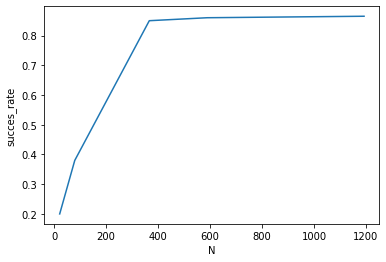

In [24]:
sns.lineplot(x = "N", y = "succes_rate", data=df)

## DAgger

As we have learned in the class, behavior cloning suffers from co-variate shift. One way to mitigate this issue is using DAgger. The key idea of DAgger is as follows: 
1. Train a behavior cloned policy $\pi_{\theta_k}$ by using an expert dataset $D$
2. Rollout the current policy $\pi_{\theta_k}$ and get a trajectory $(s_0, a_0, s_1, a_1, ...)$.
3. Query the expert again and get the expert actions $(a^*_0, a^*_1, ...)$. We can add these extra expert demonstration data $D_k=(s_0, a^*_0, s_1, a^*_1, ...)$ to $D$: $D=D\cup D_k$. 
4. Optimize the current policy again with the aggregated dataset $D$.
5. Repeat step 2 to 4.

In the following section, you will implement DAgger algorithm.

In [25]:
@dataclass
class DaggerAgent:
    actor: nn.Module
    expert_actor: nn.Module
    lr: float

    def __post_init__(self):
        move_to([self.actor, self.expert_actor],
                device=cfg.alg.device)
        freeze_model(self.expert_actor)
        self.optimizer = optim.Adam(self.actor.parameters(),
                                    lr=self.lr)
    
    @torch.no_grad()
    def get_action(self, ob, sample=True, *args, **kwargs):
        t_ob = torch_float(ob, device=cfg.alg.device)
        # the policy returns a multi-variate gaussian distribution
        act_dist, _ = self.actor(t_ob)
        # sample from the distribution
        action = action_from_dist(act_dist,
                                  sample=sample)
        # get the log-probability of the sampled actions
        log_prob = action_log_prob(action, act_dist)
        # get the entropy of the action distribution
        entropy = action_entropy(act_dist, log_prob)
        action_info = dict(
            log_prob=torch_to_np(log_prob),
            entropy=torch_to_np(entropy),
        )
        # get the expert action from the expert policy
        exp_act_dist, _ = self.expert_actor(t_ob)
        action_info['exp_act'] = exp_act_dist.mean
        return torch_to_np(action), action_info

    def optimize(self, data, **kwargs):
        for key, val in data.items():
            data[key] = torch_float(val, device=cfg.alg.device)
        ob = data['state']
        exp_act = data['action']
        #### TODO: optimize the policy
        action_dist, body_x = self.actor.forward(ob)
        logps = action_dist.log_prob(exp_act)
        loss = logps.sum()*-1
        self.optimizer.zero_grad()
        loss.backward()
        ####
        
        grad_norm = clip_grad(self.actor.parameters(),
                              cfg.alg.max_grad_norm)
        self.optimizer.step()

        optim_info = dict(
            loss=loss.item(),
            grad_norm=grad_norm,
        )
        return optim_info
    
    def save_model(self, is_best=False, step=None):
        data_to_save = {
            'actor_state_dict': self.actor.state_dict()
        }
        save_model(data_to_save, cfg.alg, is_best=is_best, step=step)

In [26]:
@dataclass
class DaggerEngine:
    agent: Any
    runner: Any
    env: Any
    trajs: Any

    def __post_init__(self):
        self.dataset = TrajDataset(self.trajs)
        
    def train(self):
        success_rates = []
        dataset_sizes = []
        self.cur_step = 0
        for iter_t in count():
            if iter_t % cfg.alg.eval_interval == 0:
                success_rate, ret_mean, ret_std, rets, successes = eval_agent(self.agent, 
                                                                              self.env, 
                                                                              200,
                                                                              disable_tqdm=True)
                success_rates.append(success_rate)
                dataset_sizes.append(len(self.dataset))
            # rollout the current policy and get a trajectory
            traj = self.runner(sample=True, get_last_val=False, time_steps=cfg.alg.episode_steps)
            # optimize the policy
            self.train_once(traj)
            if self.cur_step > cfg.alg.max_steps:
                break
        return dataset_sizes, success_rates

    def train_once(self, traj):
        self.cur_step += traj.total_steps

        action_infos = traj.action_infos
        exp_act = torch.stack([ainfo['exp_act'] for ainfo in action_infos])

        self.dataset.add_traj(states=traj.obs,
                              actions=exp_act.cpu())
        rollout_dataloader = DataLoader(self.dataset,
                                        batch_size=cfg.alg.batch_size,
                                        shuffle=True,
                                       )
        optim_infos = []
        for oe in range(cfg.alg.opt_epochs):
            for batch_ndx, batch_data in enumerate(rollout_dataloader):
                optim_info = self.agent.optimize(batch_data)
                optim_infos.append(optim_info)        

In [27]:
def train_dagger(expert_actor, trajs, actor=None):
    expert_actor = deepcopy(expert_actor)
    actor = deepcopy(actor)
    set_configs('dagger')
    cfg.alg.episode_steps = 30
    cfg.alg.max_steps = 1200
    cfg.alg.eval_interval = 1
    cfg.alg.log_interval = 1
    cfg.alg.batch_size = 256
    cfg.alg.opt_epochs = 500
    set_random_seed(cfg.alg.seed)
    env = make_vec_env(cfg.alg.env_name,
                       cfg.alg.num_envs,
                       seed=cfg.alg.seed)
    env.reset()
    if actor is None:
        actor = create_actor(env=env)
    dagger_agent = DaggerAgent(actor=actor, expert_actor=expert_actor, lr=0.001)
    runner = EpisodicRunner(agent=dagger_agent, env=env)
    engine = DaggerEngine(agent=dagger_agent,
                          env=env,
                          runner=runner,
                          trajs=trajs)
    dataset_sizes, success_rates = engine.train()
    return dagger_agent, dataset_sizes, success_rates

**Q2 (30 pts)**: Complete the missing code for `DaggerAgent` (define the loss function and optimize the policy). Train a DAgger agent using `train_dagger` with the behaviorally cloned agent that was trained on just one demonstration as the initial policy, $\pi_{\theta_k}$, the same demonstration as the initial dataset, $D$, and the expert that will provide expert actions as our pre-trained expert model.

Similar to Q1, plot the success rate curves for both DAgger and BC as a function of the number of expert transitions (e.g., dataset size) available at training. Your DAgger and BC curves should reach similarly high performance with enough data while DAgger will reach a high success rate earlier.

In [28]:
#### TODO: train DAgger agent and plot the success rate curves for BC and DAgger together
dagger_agent, dataset_sizes, success_rates = train_dagger(expert_agent.actor, expert_trajs, agents[0].actor)

[INFO][2022-03-03 05:19:45]: Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
[INFO][2022-03-03 05:19:45]: Creating 1 environments.
[INFO][2022-03-03 05:19:45]: Load in OpenGL!


      Device:cuda


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


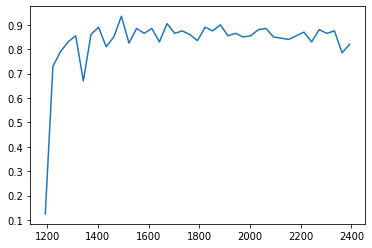

In [29]:
sns.lineplot(dataset_sizes, success_rates)

In [30]:
with open('q2_dagger_data','wb') as f:
  pickle.dump([dagger_agent, dataset_sizes, success_rates],f)

In [31]:
with open('q2_dagger_data','rb') as f:
  aye = pickle.load(f)

# RL Finetune

In DAgger, an expert is required to query the optimal action at every step during training time. However, an expert may not always be available. In the context of autonomous vehicles, for behavior cloning an expert driver is only required to collect the initial dataset of expert demonstrations while for DAgger we would need an expert to see everything the vehicle does and relabel the data in a continuous cycle during all of training. Clearly this approach does not scale, especially if obtaining these expert labels is costly.

In such cases where an expert is unavailable during the training process, if we have access to the reward function in addition to a few demonstrations, then we can combine RL and behavior cloning to improve performance. 

In the following section, we will use PPO to finetune the behavior-cloned policy. We have provided you with a `train_ppo` function that you are free to modify. Note that typically we use multi-process to roll out many agents in parallel in PPO. It typically leads to faster and more stable learning. One way to get around parallelization is to have one policy update step after collecting many rollouts with the same policy. Here, our environment terminates after $30$ steps and gets reset, but `episode_steps` is set to 900, so we will have $30$ agents' rollout experience for every single step of policy optimization.

In [ ]:
def train_ppo(actor=None, save_dir=None, max_steps=1000000):
    set_config('ppo')
    cfg.alg.num_envs = 1
    cfg.alg.episode_steps = 900
    cfg.alg.max_steps = max_steps
    cfg.alg.deque_size = 20
    cfg.alg.eval_interval = 10
    cfg.alg.log_interval = 1
    cfg.alg.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    cfg.alg.env_name = 'URPusher-v1'
    cfg.alg.save_dir = Path.cwd().absolute().joinpath('data').as_posix()
    cfg.alg.save_dir += '/rl_finetune' if save_dir is None else f'/{save_dir}'
    setattr(cfg.alg, 'diff_cfg', dict(save_dir=cfg.alg.save_dir))

    print(f'====================================')
    print(f'      Device:{cfg.alg.device}')
    print(f'      Total number of steps:{cfg.alg.max_steps}')
    print(f'====================================')

    set_random_seed(cfg.alg.seed)
    env = make_vec_env(cfg.alg.env_name,
                       cfg.alg.num_envs,
                       seed=cfg.alg.seed)
    env.reset()
    ob_size = env.observation_space.shape[0]

    if actor is None:
        actor = create_actor(env=env)
    actor = deepcopy(actor)

    critic_body = MLP(input_size=ob_size,
                     hidden_sizes=[64],
                     output_size=64,
                     hidden_act=nn.Tanh,
                     output_act=nn.Tanh)

    critic = ValueNet(critic_body, in_features=64)
    agent = PPOAgent(actor=actor, critic=critic, env=env)
    runner = EpisodicRunner(agent=agent, env=env)
    engine = PPOEngine(agent=agent,
                       runner=runner)
    engine.train()
    return agent, engine, cfg.alg.save_dir

**Q3 (20 pts)**: Compare the learning curves (both the return curve and the success rate curve) of the following two cases. Train both for 600K steps.
* train a policy from scratch for the pusher environment
* finetune a behavior-cloned policies with RL (specifically here, use the BC agent trained with 3 demonstration trajectories from Q1)

On the return and success rate curves, also plot the average return with its uncertainty as well as the average success rate for the BC agent trained on 3 demonstrations without any fine-turning (you should've cached this from Q1).

In [ ]:
#### TODO: use PPO to (1) train a policy from scratch and (2) finetune the behavior cloned policy 
#### trained with 3 demonstration trajectories


**Q (20 pts):** Do you see any difference in performance at the end of training? How about in learning or convergence rate? What about in comparison to the BC agent without fine-tuning? If so, describe them in detail.

**A:**

# Suboptimal Demonstrations

In many cases, we might not have a good expert model available. Thus, the demonstrations we get from the expert will not be optimal. In the following section, we will use a sub-optimal expert model to generate the demonstration data, use such data to train a BC agent, and see if the policy can be improved by RL.

In [ ]:
# Download the suboptimal expert model
!wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1AzWwGkOcZxrx43kNhD-7TPj06bIKRSXX' -O pusher_suboptimal_expert_model.pt

In [ ]:
# same as before, let's load a suboptimal expert model
set_configs()
env = make_vec_env(cfg.alg.env_name,
                   cfg.alg.num_envs,
                   seed=cfg.alg.seed)
sub_expert_agent = load_expert_agent(env, device=cfg.alg.device, expert_model_path='pusher_suboptimal_expert_model.pt')

In [ ]:
# let's see how good the expert model is
success_rate, ret_mean, ret_std, rets, successes = eval_agent(sub_expert_agent, env, 500)
print(f'Expert policy success rate:{success_rate}')

In [ ]:
# let's use this suboptimal expert model to generate some demonstrations
sub_expert_trajs = generate_demonstration_data(expert_agent=sub_expert_agent,
                                               env=env,
                                               num_trials=50)

**Q4.1 (10 pts)**: Similar to Q1, train a BC policy using `train_bc_agent` with $1, 3, 15, 25, 50$ suboptimal trajectories. Once you have trained the BC policy (cloned on suboptimal data), evaluate your policy on $200$ episodes and plot the average success rate (returned by 'eval_agent') as a function of the number of expert transitions used in training.

In [ ]:
### TODO run BC with 1, 3, 15, 25, 50 demonstrations respectively and plot success


**Q4.2 (20 pts)**: Similar to in Q3, run RL-finetune with the behavior-cloned policy trained from 3 suboptimal demonstration trajectories. Plot the return and success rate of the agent. On the same graph, also plot the same values for the from scratch and RL-finetune'd on 3 optimal demonstrations policies. Does RL-finetune help improve the policy performance?

**A**:

In [ ]:
### TODO finetune bc policy trained on 3 suboptimal demonstrations. 
### plot in comparison with from scratch and finetune on optimal demonstrations

# More Advanced Ideas (Bonus, Optional)

So far, we have seen how behavior cloning, DAgger, and behavior cloning with RL finetuning work. There are many more ideas one can try to make use of the demonstration data. For example, we can optimize the policy with the RL loss and behavior-cloning loss together as done in this work - [Learning Complex Dexterous Manipulation with
Deep Reinforcement Learning and Demonstrations, Equation (6)](https://arxiv.org/pdf/1709.10087.pdf) - discussed in lecture.
 
Try to implement it yourself on the Pusher environment. You are free to use any publicly avaiable RL library. You can also try out a sparse-reward setting for the Pusher environment with expert demonstrations. 

**Q (20 pts)**: Plot the return as well as the success rate curves. Compare the curves with the curves from the RL-scratch (training with RL from scratch) experiment.

**A**:


# Survey (bonus points, 10 pts)
Please fill out [this anonymous survey](https://forms.gle/WLqXaptTV22wbKdC8) and enter the code below to receive credit. Thanks!

**Code:** 